<a href="https://colab.research.google.com/github/pranshurastogi29/Data-science-interview-assignments/blob/main/dozee_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.fftpack import fft
from scipy import signal

####Since we have 5 file of 4 minute of data each now every csv has 60000 samples 
now the samples per second are 60000/240 = 250

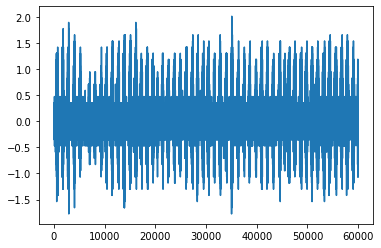

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_snoring/test5.csv')
df_og.columns=['signal']

def standard_scaler(df,drop=False):
    if drop:
      keep = df[drop]
      df = df.drop(drop, axis=1)
    mean = np.mean(df, axis=0)
    scale = np.std(df, axis=0)
    df = (df - mean) / scale  
    if drop:
      df = pd.concat((keep,df),axis=1)
    return df


def diff(series, slen=1):
    sum = 0.0
    l = []
    for i in range(len(series)-1):
        sum += float(series[i+slen] - series[i]) / slen
        l.append(float(series[i+slen] - series[i]) / slen)
    return l

df_og = standard_scaler(df_og)
df = df_og.copy()
df1 = diff(df.values)
df['signal'] = pd.Series(df1)
plt.plot(df)

data in between 400 to 900 can be termed as snoring event 

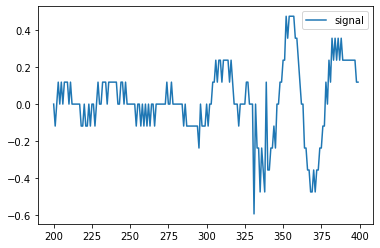

In [ ]:
df[200:400].plot()
## not snoring

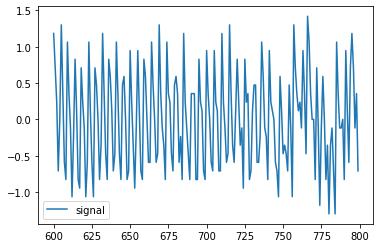

In [ ]:
df[600:800].plot()
## snoring

###So after keen looking i saw that the signal with more concentration is where the snoring is happening 

following are the things that we can explore more on 
1. vital stats like mean, median, varience
2. trends , moving averages
3. segmenting(creating segments of data on window basis) and clustering 

#### Lets check for some distribution between the snoring and not snoring data

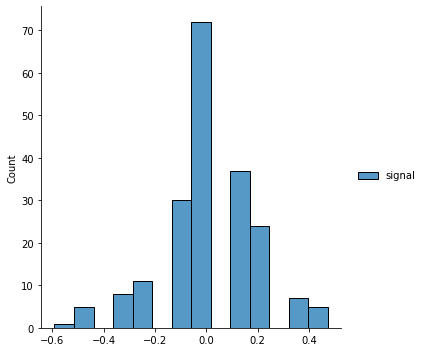

In [ ]:
sns.displot(df[200:400])

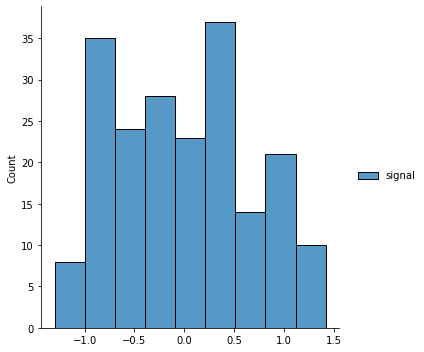

In [ ]:
sns.displot(df[600:800])

### these are the graph of distribution upper one is not snoring and lower one is snoring one but they really look the same form this histogram

lets check for some varience and mean for the segment so now we will not only work on this sample but will also take 10 samples 5 of snoring and 5 of not snoring to find some better results.


In [ ]:
## Sample not Snoring
# df[200:400]
# df[9600:9800]
# df[12400:12600]
# df[25400:25600]
# df[42400:42600]
## Sample possible snoring
# df[600:800]
# df[56600:56800]
# df[36200:36400]
# df[21400:21600]
# df[4000:4200]

not_snoring = [df[200:400],df[9600:9800],df[12400:12600],df[25400:25600],df[42400:42600]]
snoring  = [df[600:800],df[56600:56800],df[36200:36400],df[21400:21600],df[4000:4200]] 

#### now since we have some populations samples so we can do some t-test and sample testing like 2-tailed test for the population so that we can configure that the data is significantly difference

H0 = Null hypothesis that the expected values(mean) of the poplutions are same 
mean of pop1 - mean of pop2 = 0 , show that their is no significance difference between the populations 

H1 = conjugate of the H0 also called alternative hypothesis

In [ ]:
import random
import scipy
def two_tailed_t_test(a, b, alpha=0.05):
  print('snoring mean , var = ', np.mean(a.values),np.var(a.values))
  print('possible not snoring mean , var = ', np.mean(b.values),np.var(b.values))
  tval, pval = scipy.stats.ttest_ind(a, b,equal_var=False)
  print(tval, pval)
  if pval/2 < alpha:
    print('cannot reject H0(null hypothesis)')
  else:
    print('yes reject the null hypothesis')

two_tailed_t_test(snoring[0], not_snoring[0])
print('-------------------------------------')
two_tailed_t_test(snoring[1], not_snoring[1])
print('-------------------------------------')
two_tailed_t_test(snoring[2], not_snoring[2])
print('-------------------------------------')
two_tailed_t_test(snoring[3], not_snoring[3])
print('-------------------------------------')
two_tailed_t_test(snoring[4], not_snoring[4])
print('-------------------------------------')

snoring mean , var =  0.0011836135402342723 0.43555115988438275
possible not snoring mean , var =  0.014795169252928418 0.03669589864946992
[-0.27941497] [0.780175]
yes reject the null hypothesis
-------------------------------------
snoring mean , var =  -0.005918067701171367 0.3605671931245935
possible not snoring mean , var =  -0.0065098744712885044 0.020481407369337644
[0.01352435] [0.98922163]
yes reject the null hypothesis
-------------------------------------
snoring mean , var =  0.014203362482811281 0.21680402734993529
possible not snoring mean , var =  0.00355084062070282 0.077179241326574
[0.27715178] [0.7818399]
yes reject the null hypothesis
-------------------------------------
snoring mean , var =  0.008285294781639913 0.32831192724989466
possible not snoring mean , var =  0.013611555712694144 0.020198417284787214
[-0.12727442] [0.89883769]
yes reject the null hypothesis
-------------------------------------
snoring mean , var =  0.0017754203103514054 0.5325645738324611


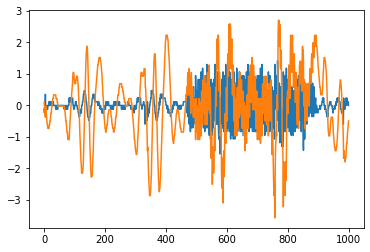

In [ ]:
plt.plot(df[:1000])
plt.plot(df_og[:1000].values)

#### This is a big lead on the plot above here we can see that the more concentrated region of the signal the differencing gives a very big disturbance or a big concentrated blob of signal with high frequency so this might be good for us to detect the snoring so now we will work on the difference section

In [ ]:
def detect_snor(df_og , faint_level = 0.43):
  """ 
  This is the main function
  the process is simple first i have 
  scaled and stationarized the signal
  and then squared the signal some signals
  are then supressed because of faintness
  then applied the gradient on the supressed 
  signals through which we can get the onset and offset
  of the snoring

  input = raw data frame
  faint_level = level of faintness the more it is 
                the more it supress
    
  return = the onset and offsets in seconds of the snoring
  """

  df_og = standard_scaler(df_og)
  df = df_og.copy()
  df1 = diff(df.values)
  df['signal'] = pd.Series(df1)
  df = np.square(df)
  l = []
  v = []
  time_slab = []
  for i in range(0,len(df)):
    if df.values.flatten()[i]>faint_level:
      l.append(i)

  bin_arr = 1*(np.gradient(l)>100)
  bin_arr[0] = 1
  for i in range(len(bin_arr)):
    if bin_arr[i]==1:
      v.append(l[i])
  i = 0
  while i<=len(v)-2:
    time_slab.append([v[i],v[i+1]])
    i = i + 2

  time_slab = pd.DataFrame(time_slab)
  time_slab.columns = ['start_time_sec','end_time_sec']
  time_slab['start_time_sec'] = time_slab['start_time_sec']/250
  time_slab['end_time_sec'] = time_slab['end_time_sec']/250
  return time_slab

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_snoring/test5.csv')
df_og.columns=['signal']
time_slab = detect_snor(df_og)

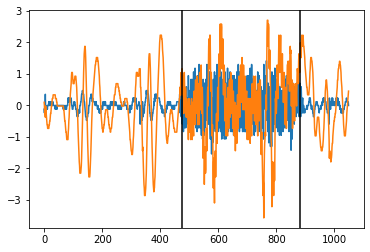

In [ ]:
i=0
df_og = standard_scaler(df_og)
plt.plot(df[i*1000:(i+1)*1050])
plt.plot(df_og[i*1000:(i+1)*1050])
plt.axvline(x=time_slab.values[0][0]*250,c='black')
plt.axvline(x=time_slab.values[0][1]*250,c='black')

###In finding the movement our task is to find the whether there is movement in a second or not i have used the same procedure not very much different

In [ ]:
def scale_down(series):
  series = (series - min(series)) / max(series)
  return series

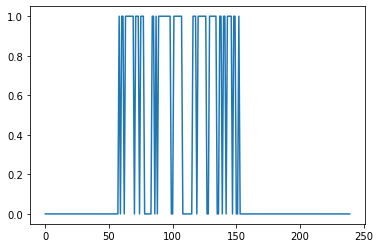

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_movement/test1.csv')
df_og.columns=['signal']

def find_mov_per_sec(df_og, threshold_no_spikes = 3):
  """ 
  the procedure is same here i have squared the gradient with same suppression 
  technique

  input_data = raw data frame

  threshold_no_spikes = number of spikes per second below this is not considered

  output = list showing whether the second has movement or not
  
  """
  df_og = standard_scaler(df_og)
  df_og = np.square(df_og)
  values = scale_down(np.gradient(df_og.values.flatten())**2)
  values = 1*(values>0.2)

  out = []
  for i in range(0 , len(values), 250):
    if np.sum(values[i:i+250])>=threshold_no_spikes:
      out.append(1)
    else:
      out.append(0)
  plt.plot(out)
  return out

time_slab_per_sec = find_mov_per_sec(df_og)

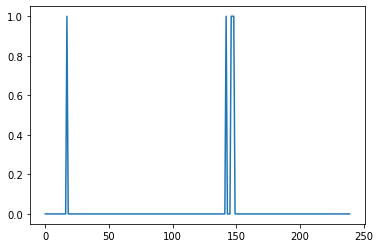

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_movement/test2.csv')
df_og.columns=['signal']
time_slab_per_sec = find_mov_per_sec(df_og)

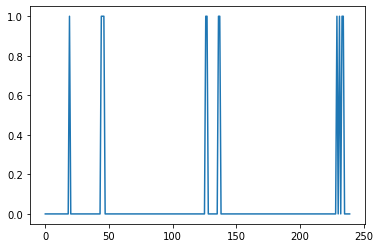

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_movement/test3.csv')
df_og.columns=['signal']
time_slab_per_sec = find_mov_per_sec(df_og)

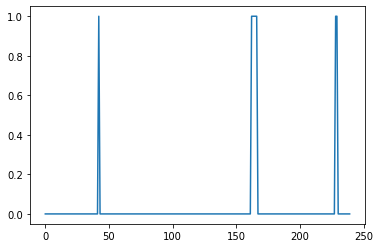

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_movement/test4.csv')
df_og.columns=['signal']
time_slab_per_sec = find_mov_per_sec(df_og)

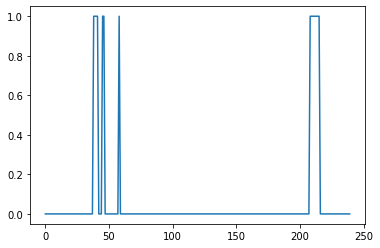

In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/test_data_movement/test5.csv')
df_og.columns=['signal']
time_slab_per_sec = find_mov_per_sec(df_og)